
# Comparison of kernel ridge and Gaussian process regression

This example illustrates differences between a kernel ridge regression and a
Gaussian process regression.

Both kernel ridge regression and Gaussian process regression are using a
so-called "kernel trick" to make their models expressive enough to fit
the training data. However, the machine learning problems solved by the two
methods are drastically different.

Kernel ridge regression will find the target function that minimizes a loss
function (the mean squared error).

Instead of finding a single target function, the Gaussian process regression
employs a probabilistic approach : a Gaussian posterior distribution over
target functions is defined based on the Bayes' theorem, Thus prior
probabilities on target functions are being combined with a likelihood function
defined by the observed training data to provide estimates of the posterior
distributions.

We will illustrate these differences with an example and we will also focus on
tuning the kernel hyperparameters.


In [1]:
# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#          Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: BSD 3 clause

In [2]:
import os
import sys
import time

import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
%matplotlib inline 

## Generating a dataset

We create a synthetic dataset. The true generative process will take a 1-D
vector and compute its sine. Note that the period of this sine is thus
$2 \pi$. We will reuse this information later in this example.



In [3]:
rng = np.random.RandomState(0)
X = np.linspace(0, 100, num=1_000).reshape(-1, 1)
Y = np.sin(X).ravel()

In [4]:
X.shape, Y.shape

((1000, 1), (1000,))

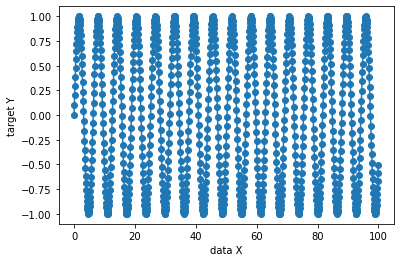

In [5]:
plt.plot(X,Y, '-o');
plt.xlabel("data X")
plt.ylabel("target Y")
plt.show()

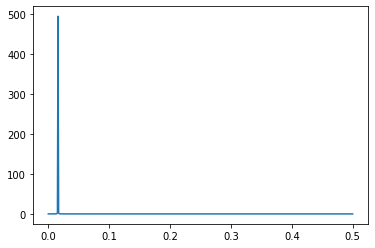

In [6]:
f, Pxx = signal.periodogram(Y)
plt.plot(f, Pxx);

In [7]:
top_3_periods = {}

# get indices for 3 highest Pxx values
top3_freq_indices = np.flip(np.argsort(Pxx), 0)[0:3]

# use indices from previous step to
# get 3 frequencies with highest power
freqs = f[top3_freq_indices]

# use same indices to get powers as well
power = Pxx[top3_freq_indices]

# we are interested in period and it is calculated as 1/frequency 
periods = 1 / np.array(freqs)

# populate dict with calculated values
top_3_periods['period1'] = periods[0]
top_3_periods['freq1'] = freqs[0]
top_3_periods['power1'] = power[0]

top_3_periods['period2'] = periods[1]
top_3_periods['freq2'] = freqs[1]
top_3_periods['power2'] = power[1]

top_3_periods['period3'] = periods[2]
top_3_periods['freq3'] = freqs[2]
top_3_periods['power3'] = power[2]

In [8]:
top_3_periods

{'period1': 62.5,
 'freq1': 0.016,
 'power1': 494.1412673152134,
 'period2': 66.66666666666667,
 'freq2': 0.015,
 'power2': 2.5321295934828587,
 'period3': 58.8235294117647,
 'freq3': 0.017,
 'power3': 2.1432805971426676}

Now, we can imagine a scenario where we get observations from this true
process. However, we will add some challenges:

- the measurements will be noisy;
- only samples from the beginning of the signal will be available.



In [9]:
training_sample_indices = rng.choice(np.arange(0, 400), size=40, replace=False)

In [10]:
training_X = X[training_sample_indices]
training_Y = Y[training_sample_indices] + 0.1 * rng.randn(len(training_sample_indices))

In [11]:
training_X.shape, training_Y.shape

((40, 1), (40,))

Let's plot the true signal and the noisy measurements available for training.



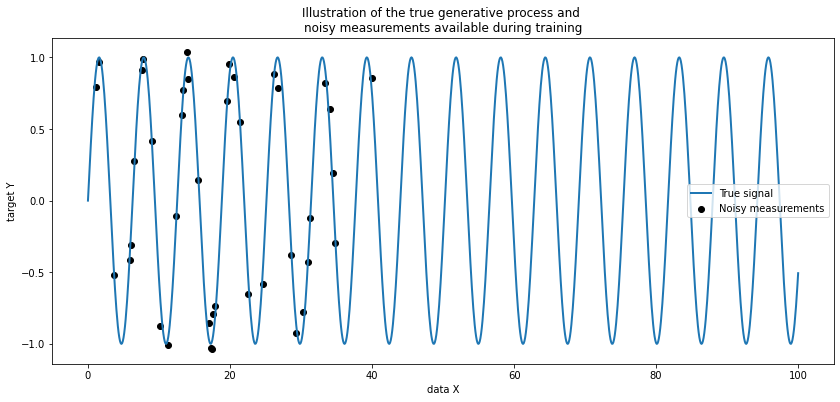

In [12]:
fig = plt.figure(figsize=(14,6))

plt.plot(X, Y, label="True signal", linewidth=2)
plt.scatter(training_X,training_Y,color="black", label="Noisy measurements",)
plt.legend()
plt.xlabel("data X")
plt.ylabel("target Y")
_ = plt.title(
    "Illustration of the true generative process and \n"
    "noisy measurements available during training")
plt.show()

## Limitations of a simple linear model

First, we would like to highlight the limitations of a linear model given
our dataset. We fit a :class:`~sklearn.linear_model.Ridge` and check the
predictions of this model on our dataset.



In [13]:
from sklearn.linear_model import Ridge

ridge = Ridge().fit(training_X, training_Y)

In [14]:
Y_predicted_ridge=ridge.predict(X)

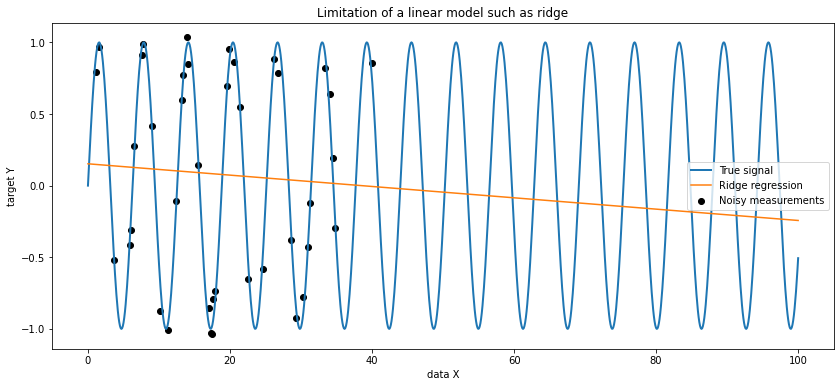

In [15]:
fig = plt.figure(figsize=(14,6))

plt.plot(X, Y, label="True signal", linewidth=2)
plt.scatter(training_X,training_Y,color="black", label="Noisy measurements",)

plt.plot(X, Y_predicted_ridge, label="Ridge regression")
plt.legend()
plt.xlabel("data X")
plt.ylabel("target Y")
_ = plt.title("Limitation of a linear model such as ridge")
plt.show()

Such a ridge regressor underfits data since it is not expressive enough.

## Kernel methods: kernel ridge and Gaussian process

### Kernel ridge

We can make the previous linear model more expressive by using a so-called
kernel. A kernel is an embedding from the original feature space to another
one. Simply put, it is used to map our original data into a newer and more
complex feature space. This new space is explicitly defined by the choice of
kernel.

In our case, we know that the true generative process is a periodic function.
We can use a :class:`~sklearn.gaussian_process.kernels.ExpSineSquared` kernel
which allows recovering the periodicity. The class
:class:`~sklearn.kernel_ridge.KernelRidge` will accept such a kernel.

Using this model together with a kernel is equivalent to embed the data
using the mapping function of the kernel and then apply a ridge regression.
In practice, the data are not mapped explicitly; instead the dot product
between samples in the higher dimensional feature space is computed using the
"kernel trick".

Thus, let's use such a :class:`~sklearn.kernel_ridge.KernelRidge`.



In [16]:
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.kernel_ridge import KernelRidge

kernel_ridge = KernelRidge(kernel=ExpSineSquared())

In [17]:
start_time = time.time()
kernel_ridge.fit(training_X, training_Y)
print(f"Fitting KernelRidge with default kernel: {time.time() - start_time:.3f} seconds")

Fitting KernelRidge with default kernel: 0.026 seconds


In [18]:
Y_predicted_kr=kernel_ridge.predict(X)

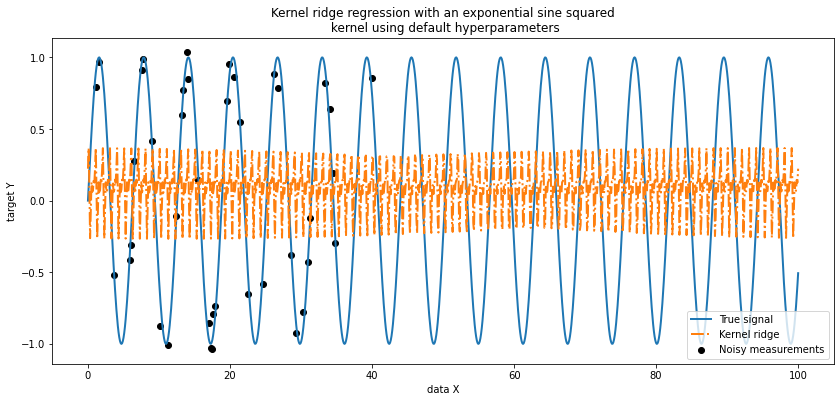

In [19]:
fig = plt.figure(figsize=(14,6))

plt.plot(X, Y, label="True signal", linewidth=2)
plt.scatter(training_X,training_Y,color="black", label="Noisy measurements",)
plt.plot(X, Y_predicted_kr,label="Kernel ridge",linewidth=2,linestyle="dashdot",)
plt.legend(loc="lower right")
plt.xlabel("data X")
plt.ylabel("target Y")
_ = plt.title(
    "Kernel ridge regression with an exponential sine squared\n "
    "kernel using default hyperparameters")
plt.show()

This fitted model is not accurate. Indeed, we did not set the parameters of
the kernel and instead used the default ones. We can inspect them.



In [20]:
kernel_ridge.kernel

ExpSineSquared(length_scale=1, periodicity=1)

Our kernel has two parameters: the length-scale and the periodicity. For our
dataset, we use `sin` as the generative process, implying a
$2 \pi$-periodicity for the signal. The default value of the parameter
being $1$, it explains the high frequency observed in the predictions of
our model.
Similar conclusions could be drawn with the length-scale parameter. Thus, it
tell us that the kernel parameters need to be tuned. We will use a randomized
search to tune the different parameters the kernel ridge model: the `alpha`
parameter and the kernel parameters.



In [21]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform

param_distributions = {
    "alpha": loguniform(1e0, 1e3),
    "kernel__length_scale": loguniform(1e-2, 1e2),
    "kernel__periodicity": loguniform(1e0, 1e1),
}

kernel_ridge_tuned = RandomizedSearchCV(
    kernel_ridge,
    param_distributions=param_distributions,
    n_iter=5000,
    random_state=0,
)

In [22]:
start_time = time.time()
kernel_ridge_tuned.fit(training_X, training_Y)
print(f"Time for KernelRidge fitting: {time.time() - start_time:.3f} seconds")

Time for KernelRidge fitting: 40.704 seconds


Fitting the model is now more computationally expensive since we have to try
several combinations of hyperparameters. We can have a look at the
hyperparameters found to get some intuitions.



In [23]:
kernel_ridge_tuned.best_params_

{'alpha': 1.1845896881491766,
 'kernel__length_scale': 0.5326832013729961,
 'kernel__periodicity': 6.3231922852761935}

Looking at the best parameters, we see that they are different from the
defaults. We also see that the periodicity is closer to the expected value:
$2 \pi$. We can now inspect the predictions of our tuned kernel ridge.



In [24]:
start_time = time.time()
Y_predicted_kr_opt = kernel_ridge_tuned.predict(X)
print(f"Time for KernelRidge predict: {time.time() - start_time:.3f} seconds")

Time for KernelRidge predict: 0.005 seconds


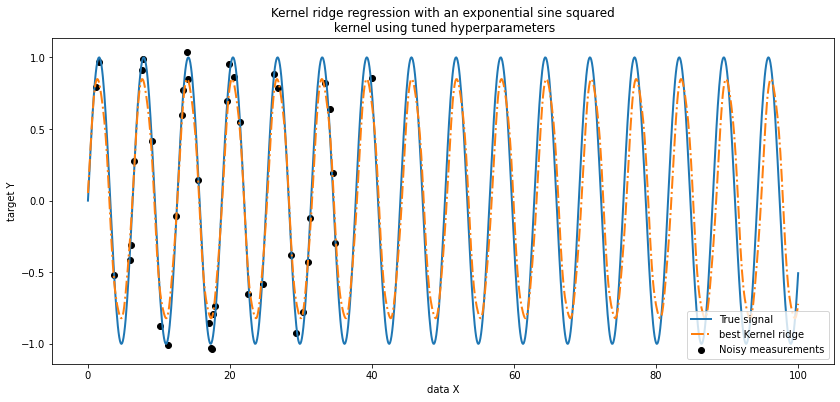

In [25]:
fig = plt.figure(figsize=(14,6))

plt.plot(X, Y, label="True signal", linewidth=2)
plt.scatter(training_X,training_Y,color="black", label="Noisy measurements",)
plt.plot(X,Y_predicted_kr_opt,label="best Kernel ridge",linewidth=2,linestyle="dashdot",)
plt.legend(loc="lower right")
plt.xlabel("data X")
plt.ylabel("target Y")
_ = plt.title(
    "Kernel ridge regression with an exponential sine squared\n "
    "kernel using tuned hyperparameters")
plt.show()

In [26]:
X_valid=np.linspace(30, 40, num=40).reshape(-1, 1)

In [27]:
Y_valid_kr_opt=kernel_ridge_tuned.predict(X_valid)

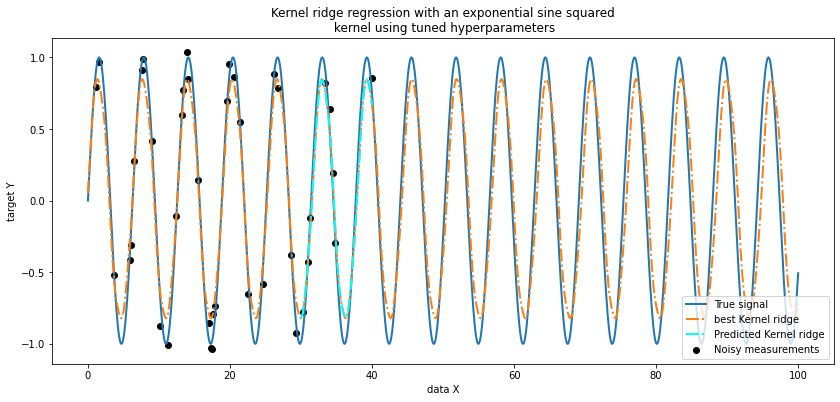

In [28]:
fig = plt.figure(figsize=(14,6))

plt.plot(X, Y, label="True signal", linewidth=2)
plt.scatter(training_X,training_Y,color="black", label="Noisy measurements",)
plt.plot(X,Y_predicted_kr_opt,label="best Kernel ridge",linewidth=2,linestyle="dashdot",)
plt.plot(X_valid,Y_valid_kr_opt,label="Predicted Kernel ridge",linewidth=2,linestyle="dashdot", color='cyan')

plt.legend(loc="lower right")
plt.xlabel("data X")
plt.ylabel("target Y")
_ = plt.title(
    "Kernel ridge regression with an exponential sine squared\n "
    "kernel using tuned hyperparameters")
plt.show()

We get a much more accurate model. We still observe some errors mainly due to
the noise added to the dataset.

### Gaussian process regression

Now, we will use a
:class:`~sklearn.gaussian_process.GaussianProcessRegressor` to fit the same
dataset. When training a Gaussian process, the hyperparameters of the kernel
are optimized during the fitting process. There is no need for an external
hyperparameter search. Here, we create a slightly more complex kernel than
for the kernel ridge regressor: we add a
:class:`~sklearn.gaussian_process.kernels.WhiteKernel` that is used to
estimate the noise in the dataset.



In [29]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel

kernel = 1.0 * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) + WhiteKernel(1e-1)
gaussian_process = GaussianProcessRegressor(kernel=kernel)

In [30]:
kernel(X).shape

(1000, 1000)

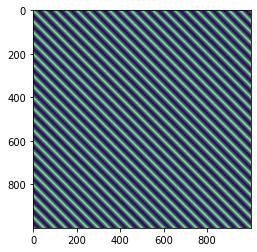

In [31]:
plt.imshow(kernel(X));
plt.show()

In [32]:
start_time = time.time()

gaussian_process.fit(training_X, training_Y)
print(f"Time for GaussianProcessRegressor fitting: {time.time() - start_time:.3f} seconds")

Time for GaussianProcessRegressor fitting: 0.461 seconds


The computation cost of training a Gaussian process is much less than the
kernel ridge that uses a randomized search. We can check the parameters of
the kernels that we computed.



In [33]:
gaussian_process.kernel_

0.973**2 * ExpSineSquared(length_scale=1.77, periodicity=6.29) + WhiteKernel(noise_level=0.00638)

Indeed, we see that the parameters have been optimized. Looking at the
`periodicity` parameter, we see that we found a period close to the
theoretical value $2 \pi$. We can have a look now at the predictions of
our model.



In [34]:
start_time = time.time()
Y_mean_predictions_gpr, Y_std_predictions_gpr = gaussian_process.predict(X,return_std=True,)
print(f"Time for GaussianProcessRegressor predict: {time.time() - start_time:.3f} seconds")

Time for GaussianProcessRegressor predict: 0.051 seconds


In [35]:
start_time = time.time()
Y_mean_predictions_gpr, Y_std_predictions_gpr = gaussian_process.predict(X,return_std=True,)
print(f"Time for GaussianProcessRegressor predict: {time.time() - start_time:.3f} seconds")

Time for GaussianProcessRegressor predict: 0.007 seconds


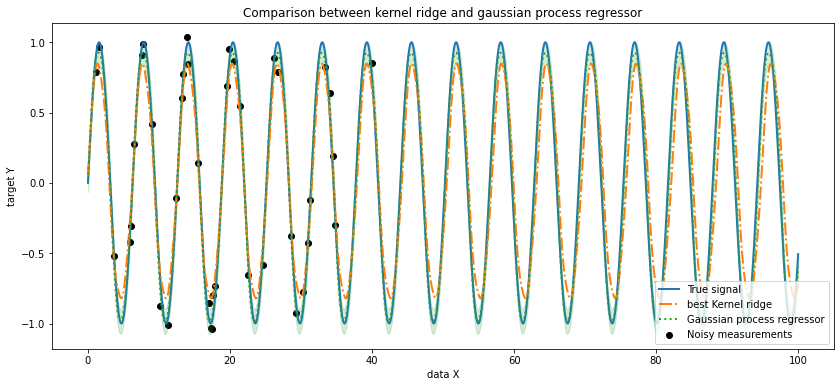

In [36]:
fig = plt.figure(figsize=(14,6))

plt.plot(X, Y, label="True signal", linewidth=2)
plt.scatter(training_X,training_Y,color="black", label="Noisy measurements",)
# Plot the predictions of the kernel ridge
plt.plot(X,Y_predicted_kr_opt,label="best Kernel ridge",linewidth=2,linestyle="dashdot",)
# Plot the predictions of the gaussian process regressor
plt.plot(X,Y_mean_predictions_gpr,label="Gaussian process regressor",linewidth=2,linestyle="dotted",)
plt.fill_between(X.ravel(),
                 Y_mean_predictions_gpr - Y_std_predictions_gpr,
                 Y_mean_predictions_gpr + Y_std_predictions_gpr,
                color="tab:green", alpha=0.2,)

plt.legend(loc="lower right")
plt.xlabel("data X")
plt.ylabel("target Y")
_ = plt.title("Comparison between kernel ridge and gaussian process regressor")
plt.show()

In [37]:
Y_mean_valid_gpr, Y_std_valid_gpr = gaussian_process.predict(X_valid,return_std=True,)

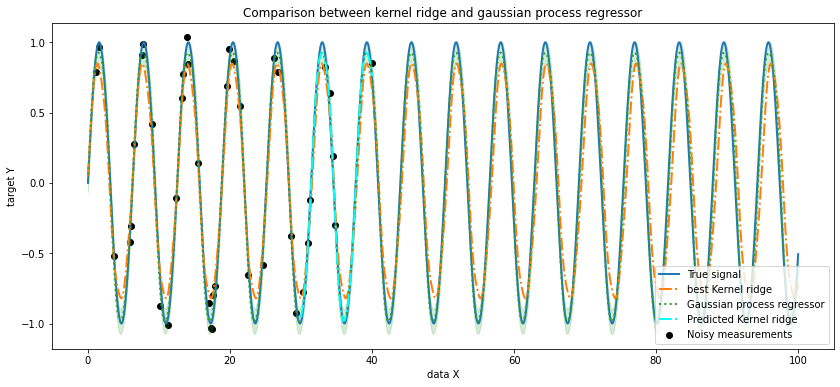

In [38]:
fig = plt.figure(figsize=(14,6))

plt.plot(X, Y, label="True signal", linewidth=2)
plt.scatter(training_X,training_Y,color="black", label="Noisy measurements",)
# Plot the predictions of the kernel ridge
plt.plot(X,Y_predicted_kr_opt,label="best Kernel ridge",linewidth=2,linestyle="dashdot",)
# Plot the predictions of the gaussian process regressor
plt.plot(X,Y_mean_predictions_gpr,label="Gaussian process regressor",linewidth=2,linestyle="dotted",)
plt.fill_between(X.ravel(),
                 Y_mean_predictions_gpr - Y_std_predictions_gpr,
                 Y_mean_predictions_gpr + Y_std_predictions_gpr,
                color="tab:green", alpha=0.2,)
plt.plot(X_valid,Y_mean_valid_gpr,label="Predicted Kernel ridge",linewidth=2,linestyle="dashdot", color='cyan')

plt.legend(loc="lower right")
plt.xlabel("data X")
plt.ylabel("target Y")
_ = plt.title("Comparison between kernel ridge and gaussian process regressor")
plt.show()

We observe that the results of the kernel ridge and the Gaussian process
regressor are close. However, the Gaussian process regressor also provide
an uncertainty information that is not available with a kernel ridge.
Due to the probabilistic formulation of the target functions, the
Gaussian process can output the standard deviation (or the covariance)
together with the mean predictions of the target functions.

However, it comes at a cost: the time to compute the predictions is higher
with a Gaussian process.

## Final conclusion

We can give a final word regarding the possibility of the two models to
extrapolate. Indeed, we only provided the beginning of the signal as a
training set. Using a periodic kernel forces our model to repeat the pattern
found on the training set. Using this kernel information together with the
capacity of the both models to extrapolate, we observe that the models will
continue to predict the sine pattern.

Gaussian process allows to combine kernels together. Thus, we could associate
the exponential sine squared kernel together with a radial basis function
kernel.



In [39]:
from sklearn.gaussian_process.kernels import RBF

kernel = 1.0 * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e2)) * RBF(
    length_scale=15, length_scale_bounds="fixed") + WhiteKernel(1e-1)

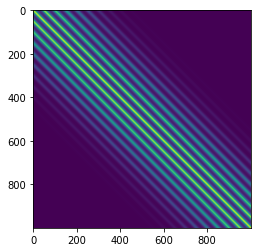

In [40]:
plt.imshow(kernel(X));
plt.show()

In [41]:
gaussian_process = GaussianProcessRegressor(kernel=kernel)
gaussian_process.fit(training_X, training_Y)

Y_mean_predictions_gpr, Y_std_predictions_gpr = gaussian_process.predict(X,return_std=True,)

In [42]:
Y_mean_valid_gpr, Y_std_valid_gpr = gaussian_process.predict(X_valid,return_std=True,)

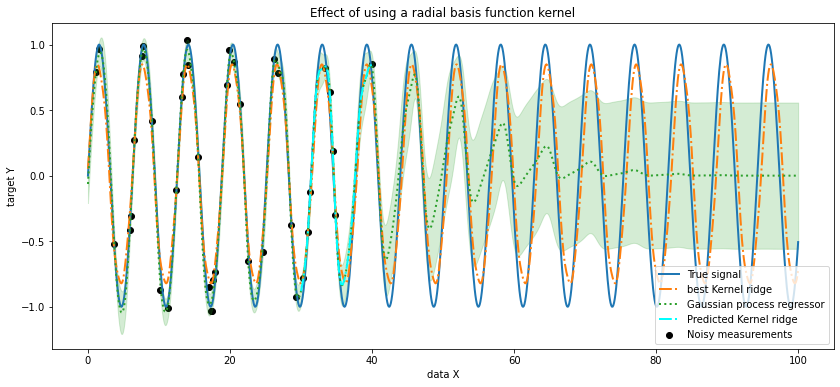

In [43]:
fig = plt.figure(figsize=(14,6))

plt.plot(X, Y, label="True signal", linewidth=2)
plt.scatter(training_X,training_Y,color="black", label="Noisy measurements",)
# Plot the predictions of the kernel ridge
plt.plot(X,Y_predicted_kr_opt,label="best Kernel ridge",linewidth=2,linestyle="dashdot",)
# Plot the predictions of the gaussian process regressor
plt.plot(X,Y_mean_predictions_gpr,label="Gaussian process regressor",linewidth=2,linestyle="dotted",)
plt.fill_between(X.ravel(),
                 Y_mean_predictions_gpr - Y_std_predictions_gpr,
                 Y_mean_predictions_gpr + Y_std_predictions_gpr,
                color="tab:green", alpha=0.2,)
plt.plot(X_valid,Y_mean_valid_gpr,label="Predicted Kernel ridge",linewidth=2,linestyle="dashdot", color='cyan')

plt.legend(loc="lower right")
plt.xlabel("data X")
plt.ylabel("target Y")
_ = plt.title("Effect of using a radial basis function kernel")
plt.show()

The effect of using a radial basis function kernel will attenuate the
periodicity effect once that no sample are available in the training.
As testing samples get further away from the training ones, predictions
are converging towards their mean and their standard deviation
also increases.

